# Gendered Language Annotation in brat

Annotation workflow:
1. Load metadata descriptions for annotation into [brat](https://brat.nlplab.org/) [completed]
2. Specify annotation schema in brat [completed]
3. Set up five annotator accounts [completed]
4. Annotate descriptions [completed]
5. Export annotations [completed]
6. Evaluate inter-annotator agreement (IAA)
***
TABLE OF CONTENTS

**I. [Build Annotation DataFrames](#dfs)**
  
  i. [Functions](#fnct)
  
  ii. [Annotator Data Loading](#load)

**II. [Inter-Annotator Agreement (IAA)](#iaa)**

  i. [Prepare the Data](#prep)

  ii. [Functions: Find True/False Positives and True/False Negatives](#tfptfn)

   * [Contextual Label Analysis](#cont)
   * [Linguistic and Person-Name Label Analysis](#ling-pers)
  
  
  iii. [Calculate IAA](#iaa)
  
  iv. [With bratiaa](#bratiaa)
  
***

#### Import libraries:

In [12]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
# nltk.download('averaged_perceptron_tagger')
# from nltk.tag import pos_tag
import string
import csv
import re
import os
from intervaltree import Interval, IntervalTree
# import seaborn as sn
# import matplotlib.pyplot as plt
# from bokeh.plotting import figure,show
# from bokeh.io import output_notebook
# from bokeh.palettes import Turbo256, viridis
# from bokeh.models.mappers import CategoricalColorMapper
# output_notebook()

#### Remove Unannotated Files:
* Annotator 0 labeled through file Coll-146_00800
* Annotator 1 labeled through file Coll-1434_14700
* Annotator 2 labeled through file Coll-146_28300
* Annotator 3 labeled through file Coll-1434_14700
* Annotator 4 labeled through file Coll-1497_00400

In [2]:
def removeUnannotatedFiles(filepath, last_ann_file):
    filenames = os.listdir(filepath)
    filenames.sort()
    start_len = len(filenames)
    # Remove unannotated files
    i = filenames.index(last_ann_file) + 1
    last_i = len(filenames) - 1
    while i <= last_i:
        f = os.path.join(filepath, filenames[i])
        if os.path.exists(f):
            os.remove(f)
        i += 1
    # Remove the first file in the directory, .stats_cache
    stats_cache = os.path.join(filepath, filenames[0])
    if os.path.exists(stats_cache):
        os.remove(stats_cache)
        
    end_len = len(os.listdir(filepath))
    
    print("Removed "+str(start_len - end_len)+" files from "+filepath)

In [3]:
# # Annotator 0
# removeUnannotatedFiles("../IAA/annotator-0", "Coll-146_00800.txt")
# ann0 = os.listdir("../IAA/annotator-0")
# ann0.sort()
# print(ann0)  # Looks good!

Removed 1 files from ../IAA/annotator-0
['AA4_00100.txt', 'AA5_00100.ann', 'AA5_00100.txt', 'AA6_00100.ann', 'AA6_00100.txt', 'AA7_00100.ann', 'AA7_00100.txt', 'BAI_00100.ann', 'BAI_00100.txt', 'BAI_00200.ann', 'BAI_00200.txt', 'BAI_00300.ann', 'BAI_00300.txt', 'BAI_00400.ann', 'BAI_00400.txt', 'BAI_00500.ann', 'BAI_00500.txt', 'BAI_00600.ann', 'BAI_00600.txt', 'BAI_00700.ann', 'BAI_00700.txt', 'BAI_00800.ann', 'BAI_00800.txt', 'BAI_00900.ann', 'BAI_00900.txt', 'BAI_01000.ann', 'BAI_01000.txt', 'BAI_01100.ann', 'BAI_01100.txt', 'BAI_01200.ann', 'BAI_01200.txt', 'BAI_01300.ann', 'BAI_01300.txt', 'BAI_01400.ann', 'BAI_01400.txt', 'BAI_01500.ann', 'BAI_01500.txt', 'BAI_01600.ann', 'BAI_01600.txt', 'BAI_01700.ann', 'BAI_01700.txt', 'BAI_01800.ann', 'BAI_01800.txt', 'BAI_01900.ann', 'BAI_01900.txt', 'BAI_02000.ann', 'BAI_02000.txt', 'BAI_02100.ann', 'BAI_02100.txt', 'BAI_02200.ann', 'BAI_02200.txt', 'BAI_02300.ann', 'BAI_02300.txt', 'BAI_02400.ann', 'BAI_02400.txt', 'BAI_02500.ann', 'BAI_02

In [4]:
# removeUnannotatedFiles("../IAA/Linguistic/annotator-1", "Coll-1434_14700.txt") # Annotator 1
# removeUnannotatedFiles("../IAA/Linguistic/annotator-2", "Coll-146_28300.txt")  # Annotator 2
# removeUnannotatedFiles("../IAA/Contextual/annotator-3", "Coll-1434_14700.txt") # Annotator 3
# removeUnannotatedFiles("../IAA/Contextual/annotator-4", "Coll-1497_00400.txt") # Annotator 4

Removed 1 files from ../IAA/Linguistic/annotator-1
Removed 2 files from ../IAA/Linguistic/annotator-2
Removed 1 files from ../IAA/Contextual/annotator-3
Removed 1 files from ../IAA/Contextual/annotator-4


Create directories of files that were annotated by:
* Annotators 1 and 2 (with Linguistic + Person-Name labels)
* Annotators 0 and 1 (with Linguistic + Person-Name labels)
* Annotators 0 and 2 (with Linguistic + Person-Name labels)
* Annotators 3 and 4 (with Contextual labels)
* Annotators 0 and 3 (with Contextual labels)
* Annotators 0 and 4 (with Contextual labels)

Also...
* Annotators 0, 1, and 2 (with Linguistic + Person-Name labels)?
* Annotators 0, 3, and 4 (with Contextual labels)?

#### Fix Errors in Labeled Data:
* `Person-Name` labels should be a different sub-category label
* Errors found in manual review for each subcategory

<a id="dfs"></a>
## I. Build Annotation DataFrames
For each of the five annotators, build one DataFrame of notes and one DataFrame of labels, resulting in two DataFrames per annotator and ten DataFrames total.

<a id="#fnct"></a>
### I.i. Functions

#### Annotations to Remove:

In [5]:
# Create a dictionary of mistaken annotations (due to non-ASCII characters in dataset) to exclude from the DataFrames
to_remove = pd.read_csv("../IAA/AnnsToRemove.csv", names = ["file", "bad_annotations"])
# to_remove
bad_anns = list(to_remove["bad_annotations"])
# print(bad_anns)
bad_anns_lists = []
bad_files = list(to_remove.file)
to_remove_dict = {}
# print(bad_files)

i = 0
maxI = len(bad_files)
while i < maxI:
    a = bad_anns[i]
    a_list = a.split("\n")
    f = bad_files[i]
    to_remove_dict[f] = a_list
    i += 1
print(to_remove_dict)

{'Coll-1289_00100': ['T0 Gendered-Role 299 303 duke', 'T2 Gendered-Pronoun 152 155 him'], 'Coll-1383_00300': ['T0 Gendered-Role 516 519 Sir'], 'Coll-1383_00400': ['T0 Gendered-Role 305 308 Sir', 'T1 Gendered-Role 386 389 Sir', 'T2 Gendered-Role 852 854 MS', 'T3 Gendered-Role 2879 2888 gentleman', 'T4 Gendered-Role 2936 2947 grandmother'], 'Coll-1383_00500': ['T0 Gendered-Role 300 302 Mr', 'T1 Gendered-Role 587 589 Mr', 'T2 Gendered-Role 619 621 Mr', 'T3 Gendered-Role 689 692 Sir', 'T4 Gendered-Role 795 799 king'], 'Coll-1405_00100': ['T1 Gendered-Role 1945 1948 son', 'T8 Gendered-Pronoun 1628 1630 He', 'T9 Gendered-Pronoun 1876 1878 he'], 'Coll-1434_08300': ['T0 Gendered-Role 322 326 Duke'], 'Coll-1434_09600': ['T2 Gendered-Pronoun 359 362 His'], 'Coll-1434_10600': ['T0 Gendered-Role 1635 1642 Duchess'], 'Coll-1434_10900': ['T0 Gendered-Role 35 40 Queen'], 'Coll-1434_11200': ['T3 Gendered-Role 5062 5065 Sir', 'T7 Gendered-Pronoun 5170 5173 his'], 'Coll-1434_11800': ['T0 Gendered-Role 3

In [6]:
# Extract comments from files and put in a DataFrame

### Annotation Format (comments begin with #):
# T1	Unknown 17 24	Thomson
# T2	Omission 17 24	Thomson
# #1	AnnotatorNotes T2	Last name only

# INPUT: Annotation file from brat (ending in .ann)
# OUTPUT: List of labels and list of notes from the .ann file (empty if none in file)
def extractLabelsAndNotes(ann_file, to_ignore):
    f = open(ann_file, "r")
    labels = []
    notes = []
    
    # If the file isn't empty, populate the labels and notes lists
    if os.path.getsize(ann_file) > 0:
        lines = f.readlines()
        for l in lines:
            if (l[0] == "T") and (l not in to_ignore):   # only add labels (marked with T) that aren't mistakenly recorded             
                labels += [l]
            elif l[0] == "#":                            # only add annotator's notes about a label (marked with #)
                notes += [l]
    
    return labels, notes

**Notes Data Functions:**

In [7]:
def getNotesColumns(notes_dict):
    col_file, col_entity, col_note = [], [], []
    for f,notes in notes_dict.items():
        for n in notes:
            col_file += [f]
            n.strip()  # remove leading and trailing whitespace
            n_split = n.split("\t")
            col_entity += [n_split[1].replace("AnnotatorNotes ","")]
            col_note += [n_split[2]]

    assert len(col_file) == len(col_entity)
    assert len(col_entity) == len(col_note)

    return col_file, col_entity, col_note

In [8]:
def buildNotesDataFrame(annotator, col_file, col_entity, col_note):
    df_notes = pd.DataFrame({"file":col_file, "entity":col_entity, "note":col_note})
    df_notes['annotator'] = [annotator for x in range(df_notes.shape[0])]
    return df_notes

**Labels Data Functions:**

In [9]:
# Check for tab-separated annotation data
def filesWithoutTabbedAnnotations(labels_dict):
    to_fix = {}
    for f,labels in labels_dict.items():
        for l in labels:
            if "\t" not in l:
                to_fix[f] = l
    return to_fix

In [10]:
def getLabelsColumns(labels_dict):
    col_file, col_entity, col_label, col_offset1, col_offset2, col_text = [], [], [], [], [], []
    for f,labels in labels_dict.items():
        for l in labels:
            if len(l) > 0:
                col_file += [f]
                l = l.strip()                               # remove leading and trailing whitespace
                l = l.split("\t")                           # split entity, label+offsets, and text
                
                # Add entity to column list (example: T2)
                col_entity += [l[0]]
                
                # Add text to column list (example: "Miss")
                try:
                    col_text += [l[2]]
                except IndexError:
                    return f, None, None, None, None, l
                # Split label, start offset, and end offset and
                # add each to their corresponding column list
                label_offsets = l[1] 
                label_offsets = label_offsets.split(" ")    # split label, start offset, and end offset
                col_label += [label_offsets[0]]
                col_offset1 += [label_offsets[1]]
                col_offset2 += [label_offsets[2]]

    assert len(col_file) == len(col_entity)
    assert len(col_entity) == len(col_label)
    assert len(col_label) == len(col_offset1)
    assert len(col_offset1) == len(col_offset2)
    assert len(col_offset2) == len(col_text)

    return col_file, col_entity, col_label, col_offset1, col_offset2, col_text

# Sample labels data from brat
# ['T0\tGendered-Pronoun 311 314\tShe\n',
#  ...
#  ]

In [11]:
def buildLabelsDataFrame(annotator, col_file, col_entity, col_label, col_offset1, col_offset2, col_text):
    df_labels = pd.DataFrame({"file":col_file, "entity":col_entity, "label":col_label, "start":col_offset1, "end":col_offset2, "text":col_text})
    df_labels['annotator'] = [annotator for x in range(df_labels.shape[0])]
    return df_labels

<a id="load"></a>
### I.ii. Annotator Data Loading
First, check that the annotation files are properly formatted, with tabs and spaces in the appropriate places.

In [12]:
def getAnnLabels(dir_path, annotator, to_remove_dict):
    # Make dictionaries of labels data
    ann_files = os.listdir(dir_path)
    labels_dict = {}
    for f in ann_files:
        if ".ann" in f:   # ignore the .txt files
            file_path = os.path.join(dir_path, f)
            if f in to_remove_dict.keys():
                to_ignore = to_remove_dict[f]
            else:
                to_ignore = []
            labels, notes = extractLabelsAndNotes(file_path, to_ignore)
            labels_dict[f] = labels
    
    return labels_dict

In [14]:
# notes_dict, labels_dict = getAnnDicts("../IAA/annotator-0", "Annotator 0", to_remove_dict)
# to_fix = filesWithoutTabbedAnnotations(labels_dict)
# to_fix  # FIXED
# labels_dict = getAnnLabels("../IAA/Linguistic/annotator-1", "Annotator 1", to_remove_dict)
# to_fix = filesWithoutTabbedAnnotations(labels_dict)
# to_fix  # FIXED
# labels_dict = getAnnLabels("../IAA/Contextual/annotator-2", "Annotator 2", to_remove_dict)
# to_fix = filesWithoutTabbedAnnotations(labels_dict)
# to_fix  # NA
# labels_dict = getAnnLabels("../IAA/Contextual/annotator-3", "Annotator 3", to_remove_dict)
# to_fix = filesWithoutTabbedAnnotations(labels_dict)
# to_fix  # FIXED
# labels_dict = getAnnLabels("../IAA/Contextual/annotator-4", "Annotator 4", to_remove_dict)
# to_fix = filesWithoutTabbedAnnotations(labels_dict)
# to_fix  # NA

After manually fixing any incorrectly-formatted annotation data files listed above, create DataFrames of the annotation data and write them to CSV files:

In [15]:
def getAnnDataFrames(dir_path, annotator, to_remove_dict):
    # Make dictionaries of notes and labels data
    ann_files = os.listdir(dir_path)
    labels_dict = {}
    notes_dict = {}
    for f in ann_files:
        if ".ann" in f:   # ignore the .txt files
            file_path = os.path.join(dir_path, f)
            if f in to_remove_dict.keys():
                to_ignore = to_remove_dict[f]
            else:
                to_ignore = []
            labels, notes = extractLabelsAndNotes(file_path, to_ignore)
            labels_dict[f] = labels  # see comments below for dictionary format
            notes_dict[f] = notes    # see comments below for dictionary format

    # Build DataFrames of notes and labels data
    col_file, col_entity, col_note = getNotesColumns(notes_dict)
    df_notes = buildNotesDataFrame(annotator, col_file, col_entity, col_note)
    col_file, col_entity, col_label, col_offset1, col_offset2, col_text = getLabelsColumns(labels_dict)
    df_labels = buildLabelsDataFrame(annotator, col_file, col_entity, col_label, col_offset1, col_offset2, col_text)
    
    return df_notes, df_labels

# # SAMPLE NOTES_DICT
# # {'AA4_00100.ann': [], 'AA5_00100.ann': [], 'AA6_00100.ann': [], 
# #  'AA7_00100.ann': ['#1\tAnnotatorNotes T20\tB for Bachelor, a masculine term for a degree that can be 
# #   awarded to any gender\n'], 'BAI_00100.ann': ['#1\tAnnotatorNotes T8\tMan referenced by last name only\n'], ...}

# # SAMPLE LABELS_DICT
# # {'AA4_00100.ann': ['T0\tGendered-Pronoun 645 647\the\n', 'T1\tGendered-Pronoun 702 704\the\n', 
# #  'T2\tGendered-Pronoun 913 915\the\n', 'T3\tGendered-Pronoun 994 996\the\n', 'T4\tGendered-Pronoun 1122 1124\the\n', 
# #  'T5\tUnknown 34 56\tRev Prof John McIntyre\n', 'T10\tMan 533 546\tJohn McIntyre\n', 'T6\tMan 862 874\tRev McIntyre\n', 
# #  'T7\tOccupation 716 724\tminister\n', 'T8\tOccupation 947 968\tprofessor of divinity\n', ...] ... }

In [18]:
df_notes0, df_labels0 = getAnnDataFrames("../IAA/annotator-0", "Annotator 0", to_remove_dict)
df_notes0.head()  # Worked!
df_labels0.head()  # Worked!
Write DataFrames to CSV files
df_notes0.to_csv("notes0.csv")
df_labels0.to_csv("labels0.csv")

In [20]:
df_notes1, df_labels1 = getAnnDataFrames("../IAA/Linguistic/annotator-1", "Annotator 1", to_remove_dict)
# df_notes1.head()  # Worked!
# df_labels1.head()  # Worked!
# print(df_labels1.shape)

# Remove pre-annotated Occupation labels
df_labels1 = df_labels1[df_labels1.label != "Occupation"]
# print(df_labels1.shape)

#  Write DataFrames to CSV files
df_notes1.to_csv("notes1.csv")
df_labels1.to_csv("labels1.csv")

In [21]:
df_notes2, df_labels2 = getAnnDataFrames("../IAA/Linguistic/annotator-2", "Annotator 2", to_remove_dict)
# df_notes2.head()  # Worked!
# df_labels2.head()  # Worked!
# print(df_labels2.shape)

# Remove pre-annotated Occupation labels
df_labels2 = df_labels2[df_labels2.label != "Occupation"]
# print(df_labels2.shape)

# # Write DataFrames to CSV files
df_notes2.to_csv("notes2.csv")
df_labels2.to_csv("labels2.csv")

In [23]:
df_notes3, df_labels3 = getAnnDataFrames("../IAA/Contextual/annotator-3", "Annotator 3", to_remove_dict)
# df_notes3.head()  # Worked!
# df_labels3.head()  # Worked!
# print(df_labels3.shape)

# Remove pre-annotated Linguistic labels (Gendered-Pronoun, Gendered-Role)
df_labels3 = df_labels3[df_labels3.label != "Gendered-Pronoun"]
df_labels3 = df_labels3[df_labels3.label != "Gendered-Role"]
# print(df_labels3.shape)

# Write DataFrames to CSV files
df_notes3.to_csv("notes3.csv")
df_labels3.to_csv("labels3.csv")

In [24]:
df_notes4, df_labels4 = getAnnDataFrames("../IAA/Contextual/annotator-4", "Annotator 4", to_remove_dict)
# df_notes4.head()  # Worked!
# df_labels4.head()  # Worked!
# print(df_labels4.shape)

# Remove pre-annotated Linguistic labels (Gendered-Pronoun, Gendered-Role)
df_labels4 = df_labels4[df_labels4.label != "Gendered-Pronoun"]
df_labels4 = df_labels4[df_labels4.label != "Gendered-Role"]
# print(df_labels4.shape)

# Write DataFrames to CSV files
df_notes4.to_csv("notes4.csv")
df_labels4.to_csv("labels4.csv")

In [25]:
df_labels0.head()

,file,entity,label,start,end,text,annotator
0,Coll-1444_00100.ann,T1,Unknown,52,66,Robert E. Bell,Annotator 0
1,Coll-1444_00100.ann,T2,Generalization,219,228,Bachelors,Annotator 0
2,Coll-1444_00100.ann,T3,Generalization,301,310,Bachelors,Annotator 0
3,Coll-1444_00100.ann,T4,Generalization,368,372,Ed.B,Annotator 0
4,Coll-1444_00100.ann,T5,Generalization,377,381,M.Ed,Annotator 0


In [30]:
# Check that all Person-Name labels were removed
assert df_labels0[df_labels0.label == "Person-Name"].shape[0] == 0, "Annotator 0 shouldn't have used the Person-Name label"
assert df_labels1[df_labels1.label == "Person-Name"].shape[0] == 0, "Annotator 1 shouldn't have used the Person-Name label"
assert df_labels2[df_labels2.label == "Person-Name"].shape[0] == 0, "Annotator 2 shouldn't have used the Person-Name label"
assert df_labels3[df_labels3.label == "Person-Name"].shape[0] == 0, "Annotator 3 shouldn't have used the Person-Name label"
assert df_labels4[df_labels4.label == "Person-Name"].shape[0] == 0, "Annotator 4 shouldn't have used the Person-Name label"

<a id="iaa"></a>
## II. Inter-Annotator Agreement (IAA)
<a id="prep"></a>
### II.i Prepare the Data

#### Categories: Person-Name and Linguistic
Load the data: 

In [3]:
labels0 = pd.read_csv("./labels0.csv", index_col=0, header=0)
# Remove contextual labels from labels0
labels0PL = labels0[labels0.label != "Omission"]
labels0PL = labels0PL[labels0PL.label != "Occupation"]
labels0PL = labels0PL[labels0PL.label != "Empowering"]
labels0PL = labels0PL[labels0PL.label != "Stereotype"]

labels1 = pd.read_csv("./labels1.csv", index_col=0, header=0)

labels2 = pd.read_csv("./labels2.csv", index_col=0, header=0)

# print(labels0PL.shape)
# print(labels1.shape)
# print(labels2.shape)

 Add the label categories (either Person-Name or Linguistic) as a new column to the DataFrames:

In [4]:
person_name = ["Unknown", "Nonbinary", "Woman", "Man", "Person-Name"]
linguistic = ["Gendered-Role", "Gendered-Pronoun", "Generalization", "Linguistic"]

def addPLCategories(df, person_name, linguistic):
    categories = []
    labels_list = list(df.label)
    for label in labels_list:
        if label in person_name:
            categories += ["Person-Name"]
        elif label in linguistic:
            categories += ["Linguistic"]
        else:
            print(label)
    df["category"] = categories
    return df

In [5]:
labels0PL = addPLCategories(labels0PL, person_name, linguistic)
# labels0PL.tail()
labels1 = addPLCategories(labels1, person_name, linguistic)
# labels1.tail()
labels2 = addPLCategories(labels2, person_name, linguistic)
labels2.tail()

,file,entity,label,start,end,text,annotator,category
19894,Coll-1469_00100.ann,T12,Unknown,251,257,Ballie,Annotator 2,Person-Name
19895,Coll-1469_00100.ann,T13,Unknown,301,308,Baillie,Annotator 2,Person-Name
19896,Coll-1469_00100.ann,T14,Unknown,697,704,Baillie,Annotator 2,Person-Name
19897,Coll-1469_00100.ann,T15,Unknown,817,822,Dunne,Annotator 2,Person-Name
19898,Coll-1469_00100.ann,T16,Unknown,913,928,Graeme D. Eddie,Annotator 2,Person-Name


Replace "Woman" with "Feminine" and "Man" with "Masculine" to better represent how the data was labeled:

In [6]:
labels0PL["label"] = labels0PL["label"].replace(["Woman", "Man"], ["Feminine", "Masculine"])
# labels0PL.tail(20)  # Worked!
labels1["label"] = labels1["label"].replace(["Woman", "Man"], ["Feminine", "Masculine"])
labels2["label"] = labels2["label"].replace(["Woman", "Man"], ["Feminine", "Masculine"])

 Write the new DataFrames to CSV files:

In [7]:
# Write the DataFrames to CSV files
labels0PL.to_csv("labels0PL.csv")  # write a new CSV file for annotator 0's P & L labels only
labels1.to_csv("labels1.csv")      # replace the existing CSV file
labels2.to_csv("labels2.csv")      # replace the existing CSV file

#### Category: Contextual
Load data:

In [8]:
labels0C = labels0[labels0.label != "Gendered-Pronoun"]
labels0C = labels0C[labels0C.label != "Gendered-Role"]
labels0C = labels0C[labels0C.label != "Generalization"]
labels0C = labels0C[labels0C.label != "Linguistic"]
labels0C = labels0C[labels0C.label != "Person-Name"]
labels0C = labels0C[labels0C.label != "Unknown"]
labels0C = labels0C[labels0C.label != "Nonbinary"]
labels0C = labels0C[labels0C.label != "Woman"]
labels0C = labels0C[labels0C.label != "Man"]

labels3 = pd.read_csv("./labels3.csv", index_col=0, header=0)
labels4 = pd.read_csv("./labels4.csv", index_col=0, header=0)
labels4 = labels4[labels4.label != "Generalization"]

Add label category (Contextual):

In [9]:
contextual = ["Omission", "Occupation", "Stereotype", "Empowering", "Contextual"]
def addCCategories(df, contextual):
    categories = []
    labels_list = list(df.label)
    for label in labels_list:
        if label in contextual:
            categories += ["Contextual"]
        else:
            print(label)
    df["category"] = categories
    return df

In [10]:
labels0C = addCCategories(labels0C, contextual)
# labels0C.head()  # Worked
labels3 = addCCategories(labels3, contextual)
# labels3.head()  # Worked
labels4 = addCCategories(labels4, contextual)
labels4.head()  # Worked

,file,entity,label,start,end,text,annotator,category
0,Coll-1444_00100.ann,T1,Occupation,715,740,Educational Psychologists,Annotator 4,Contextual
1,Coll-1444_00100.ann,T2,Occupation,1664,1676,Psychologist,Annotator 4,Contextual
2,Coll-1444_00100.ann,T3,Occupation,2312,2375,researcher at the Godfrey Thomson Unit for Edu...,Annotator 4,Contextual
21,BAI_01200.ann,T19,Occupation,2347,2371,Archbishop of Canterbury,Annotator 4,Contextual
22,BAI_01200.ann,T20,Omission,2381,2397,Duke of Montrose,Annotator 4,Contextual


Write the new DataFrames to CSV files:

In [11]:
labels0C.to_csv("labels0C.csv")  # write new CSV file of annotator 0's contextual labels
labels3.to_csv("labels3.csv")    # replace existing CSV file
labels4.to_csv("labels4.csv")    # replace existing CSV file

<a id="tfptfn"></a>
### II.ii Functions: Find True/False Positives and True/False Negatives
Use the [IntervalTree](https://pypi.org/project/intervaltree/) library to find overlapping annotations (per file and per label).

In [13]:
# recall: true positive / (true positive + false negative)
# precision: true positive / (true positive + false positive)

# accuracy???: (true positive + true negative) / (true pos + false pos + true neg + false neg)
# F-score: true positive / (true pos + (1/2)(false pos + false neg))  OR (2*prec*rec)/(prec+rec)

#set_A.difference(set_B) for (A - B) (what's in A but not B)
#set_B.difference(set_A) for (B - A) (what's in B but not A)

In [61]:
# #  INPUT:  a DataFrame of an annotator's labels and a list of files to include labels from
# # OUTPUT: a list of tuples of four items (file, label, start offset, and end offset) per file (keys)
# def getFileLabelOffsets(ann_df, common_files):
#     file_list =  list(ann_df.file)
#     label = list(ann_df.label)
#     start = list(ann_df.start)
#     end = list(ann_df.end)
#     i = 0
#     maxI = len(label)
#     file_label_start_end = []
#     while i < maxI:
#         if file_list[i] in common_files:
#             file_label_start_end += [(file_list[i], label[i], start[i], end[i])]
#         i += 1
#     return set(file_label_start_end)

In [15]:
def getFileLabelOffsetsPerLabel(ann_df, common_files, chosen_label):
    label = list(ann_df.label)
    start = list(ann_df.start)
    end = list(ann_df.end)
    file_list = list(ann_df.file)
    i = 0
    maxI = len(start)
    file_label_start_end = []
    while i < maxI:
        if label[i] in chosen_label:
            if file_list[i] in common_files:
                file_label_start_end += [(file_list[i], label[i], start[i], end[i])]
        i += 1
    return set(file_label_start_end)

In [82]:
# def hasBoundaryError(start_1, start_2, end_1, end_2):
#     # left overlap
#     if start_1 <= start_2 and start_1 < end_2 and end_1 >= start_2 and end_1 < end_2:
#         return True
#     # right overlap 
#     elif start_1 > start_2 and end_1 >= end_2 and start_1 <= end_2 and end_1 > start_2:
#         return True
#     # enclosure
#     elif start_1 < start_2 and start_1 < end_2 and end_1 > start_2 and end_1 > end_2:
#         return True
#     # containment
#     elif start_1 > start_2 and start_1 < end_2 and end_1 > start_2 and end_1 < end_2:
#         return True
#     else:
#         return False

In [83]:
# #  INPUT: two lists (one for expected, one for predicted) of tuples of four items, organized as
# #         (file, label, start_offset, end_offset), where label and file are strings, and offsets are integers
# # OUTPUT: set of tuples from the first input list with overlaps with the second input list
# def findOverlaps(label_offsets1, label_offsets2):
#     overlap = []
#     for set_1 in label_offsets1:
#         try:
#             int(set_1[3])
#         except ValueError:
#             return set_1
#         else:
#             file_1, label_1, start_1, end_1 = set_1[0], set_1[1], int(set_1[2]), int(set_1[3])
#             for set_2 in label_offsets2:
#                 file_2, label_2, start_2, end_2 = set_2[0], set_2[1], int(set_2[2]), int(set_2[3])
#                 if file_1 == file_2 and label_1 == label_2:
#                     if hasBoundaryError(start_1, start_2, end_1, end_2):
#                         overlap += [set_1]
#     return set(overlap)

In [31]:
# def getFileLabelStartOffsets(ann_df, common_files):
#     label = list(ann_df.label)
#     start = list(ann_df.start)
#     file = list(ann_df.file)
#     i = 0
#     maxI = len(start)
#     file_label_start = []
#     while i < maxI:
#         if file[i] in common_files:
#             file_label_start += [(file[i], label[i], start[i])]
#         i += 1
#     return set(file_label_start)

In [32]:
# def getFileLabelStartOffsetsPerLabel(ann_df, common_files, chosen_label):
#     label = list(ann_df.label)
#     start = list(ann_df.start)
#     file = list(ann_df.file)
#     i = 0
#     maxI = len(start)
#     file_label_start = []
#     while i < maxI:
#         if label[i] in chosen_label:
#             if file[i] in common_files:
#                 file_label_start += [(file[i], label[i], start[i])]
#         i += 1
#     return set(file_label_start)

In [16]:
def makeCommonFileLabelOffsetsDf(ann_df, common_files):
    label = list(ann_df.label)
    start = list(ann_df.start)
    end = list(ann_df.end)
    file = list(ann_df.file)
    i = 0
    maxI = len(start)
    df_files, df_labels, df_starts, df_ends = [], [], [], []
    while i < maxI:
        if file[i] in common_files:
            df_files += [file[i]]
            df_labels += [label[i]]
            df_starts += [start[i]]
            df_ends += [end[i]]
        i += 1
    return pd.DataFrame({"file":df_files, "label":df_labels, "start_offset":df_starts, "end_offset":df_ends})

In [34]:
# # Code in this cell is for Contextual annotations only!
# # For measuring document-level agreement (count totals per label for each file annotated)
# def getFileLabelCounts(common_files, files_labels_starts):
#     files, labels, counts = [], [], []
#     for triple in files_labels_starts:
#         files = triple[0]
#         label = triple[1]
#         clabel_counts[file][label] = 1 + clabel_counts[file][label]
#     return files, labels, counts    

In [35]:
# def dfFromLabelCounts(clabel_counts):
#     file_names = list(clabel_counts.keys())
#     label_list = list(clabel_counts[file_names[0]].keys())
#     col_list = ["File"] + label_list
#     df_dict = dict.fromkeys(col_list, [])
#     df_dict["File"] = file_names
#     for label in label_list:
#         for f in file_names:
#             df_dict[label] = df_dict[label] + [clabel_counts[f][label]]
    
#     assert len(df_dict["File"]) == len(df_dict[label])
    
#     return pd.DataFrame(df_dict)

In [17]:
# Find the files both input annotators labeled
def findCommonFiles(df_a, df_b):
    common = []
    files_a = set(list(df_a.file))
    files_b = set(list(df_b.file))
    for f in files_a:
        if f in files_b:
            common += [f]
    return common

Create CSV files of the expected (gold's) vs. predicted (other annotator's) labels:

In [71]:
# def createExpPredDataFrame(exp_df, pred_df1, pred_df2, suffix_exp, suffix_pred1, suffix_pred2):
#     # Organize the DataFrames to be merged
#     exp_df.sort_values(["file", "category", "label", "start", "end"], inplace=True)
#     exp_df = exp_df[["file", "category", "label", "start", "end", "text"]]
#     pred_df1.sort_values(["file", "category", "label", "start", "end"], inplace=True)
#     pred_df1 = pred_df1[["file", "category", "label", "start", "end", "text"]]
#     pred_df2.sort_values(["file", "category", "label", "start", "end"], inplace=True)
#     pred_df2 = pred_df2[["file", "category", "label", "start", "end", "text"]]
    
#     # Outer join the first two DataFrames on their file, category, label, start (offset), and end (offset) columns
#     exp_pred1_df = pd.merge(exp_df, pred_df1, how="outer", 
#                            on=["file","category","label","start","end"], 
#                            suffixes=(suffix_exp, suffix_pred1))
#     # Outer join the joined and second DataFrames on their file, category, label, start (offset), and end (offset) columns
#     exp_pred1_pred2_df = pd.merge(exp_pred1_df, pred_df2, how="outer", 
#                            on=["file","category","label","start","end"])
#     exp_pred1_pred2_df.rename(columns={"text":("text"+suffix_pred2)}, inplace=True)
    
#     # Sort the data for ease of comparison for agreement/disagreement
#     exp_pred1_pred2_df.sort_values(["file", "category", "label", "start", "end"], inplace=True)
#     exp_pred1_pred2_df.reset_index(drop=True, inplace=True)
    
#     return exp_pred1_pred2_df

In [73]:
# labelsPL012 = createExpPredDataFrame(labels0PL, labels1, labels2, "_0", "_1", "_2")
# labelsPL012.head(20)

In [75]:
# labelsC034 = createExpPredDataFrame(labels0C, labels3, labels4, "_0", "_3", "_4")
# labelsC034.head(20)

Now we can study where the agreements and disagreements between annotators occurred, looking for patterns and potential ways to reconcile (such as voting, where the gold dataset goes with what most annotators labeled in each scenario) disagreements for the gold standard dataset!

To make this a bit easier with a color-code rule in Excel, let's add a column that counts the number of annotators who don't have an empty cell in each row of the DataFrames we created above:

In [80]:
# def addColorCodeCol(df, text0, text1, text2):
#     colors = []
#     i, maxI = 0, len(text0)
#     while i < maxI:
#         color = 0
#         if text0[i] == text1[i] and text1[i] == text2[i]:
#             color = 3
#         else:
#             if text0[i] or text1[i] or text2[i]:
#                 color += 1
#             if text0[i] == text1[i]:
#                 color += 1
#             if text0[i] == text2[i]:
#                 color += 1
#             if text1[i] == text2[i]:
#                 color += 1
#         colors += [color]
#         i += 1
#     df["color"] = colors
#     return df

In [83]:
# text0 = list(labelsPL012.text_0)
# text1 = list(labelsPL012.text_1)
# text2 = list(labelsPL012.text_2)
# labelsPL012 = addColorCodeCol(labelsPL012, text0, text1, text2)

In [82]:
# text0 = list(labelsC034.text_0)
# text3 = list(labelsC034.text_3)
# text4 = list(labelsC034.text_4)
# labelsC034 = addColorCodeCol(labelsC034, text0, text3, text4)
# # labelsC034.head()

In [84]:
# labelsPL012.to_csv("labelsPL012.csv")
# labelsC034.to_csv("labelsC034.csv")

Review the CSV files to find patterns in the annotators' agreements and disagreements, and to find obvious mistakes to fix in the annotation (.ann) files.

*Completed*

<a id="iaa"></a>
### II.iii Calculate IAA

Get the common files amongst the various annotator pairs between whom to measure agreement:

In [181]:
# PERSON-NAME & LINGUISTIC
labels0PL = pd.read_csv("labels0PL.csv", index_col=0)
labels1 = pd.read_csv("labels1.csv", index_col=0)
labels2 = pd.read_csv("labels2.csv", index_col=0)

commonPL01 = findCommonFiles(labels0PL, labels1)
print(len(commonPL01))  
commonPL02 = findCommonFiles(labels0PL, labels2)
print(len(commonPL02))  
commonPL12 = findCommonFiles(labels1, labels2)
print(len(commonPL12))  


# CONTEXTUAL
labels0C = pd.read_csv("labels0C.csv", index_col=0)
labels3 = pd.read_csv("labels3.csv", index_col=0)
labels4 = pd.read_csv("labels4.csv", index_col=0)

commonC03 = findCommonFiles(labels0C, labels3)
print(len(commonC03))   
commonC04 = findCommonFiles(labels0C, labels4)
print(len(commonC04))   
commonC34 = findCommonFiles(labels3, labels4)
print(len(commonC34))   

584
170
72
485
149
57


In [182]:
# Clean up the offsets (each entry should be a single integer)
def fixOffsets(df):
    start_offsets = list(df.start)
    new_start_offsets = []
    for o in start_offsets:
        o = str(o)
        if ";" in o:
            fixed = re.findall("\d+$", o)[0]
            new_start_offsets += [int(fixed)]
        else:
            new_start_offsets += [int(o)]
    df.start = new_start_offsets
    
    end_offsets = list(df.end)
    new_end_offsets = []
    for o in end_offsets:
        o = str(o)
        if ";" in o:
            fixed = re.findall("\d+$", o)[0]
            new_end_offsets += [int(fixed)]
        else:
            new_end_offsets += [int(o)]
    df.end = new_end_offsets
    
    return df

In [183]:
labels0PL = fixOffsets(labels0PL)
labels0C = fixOffsets(labels0C)
labels1 = fixOffsets(labels1)
labels2 = fixOffsets(labels2)
labels3 = fixOffsets(labels3)
labels4 = fixOffsets(labels4)

Create six dataframes for each pair of annotators between whom to analyze agreement.

In [184]:
df0_with1 = makeCommonFileLabelOffsetsDf(labels0PL, commonPL01)
df1_with0 = makeCommonFileLabelOffsetsDf(labels1, commonPL01)

df0_with2 = makeCommonFileLabelOffsetsDf(labels0PL, commonPL02)
df2_with0 = makeCommonFileLabelOffsetsDf(labels2, commonPL02)

df1_with2 = makeCommonFileLabelOffsetsDf(labels1, commonPL12)
df2_with1 = makeCommonFileLabelOffsetsDf(labels2, commonPL12)

In [185]:
df0_with3 = makeCommonFileLabelOffsetsDf(labels0C, commonC03)
df3_with0 = makeCommonFileLabelOffsetsDf(labels3, commonC03)

df0_with4 = makeCommonFileLabelOffsetsDf(labels0C, commonC04)
df4_with0 = makeCommonFileLabelOffsetsDf(labels4, commonC04)

df3_with4 = makeCommonFileLabelOffsetsDf(labels3, commonC34)
df4_with3 = makeCommonFileLabelOffsetsDf(labels4, commonC34)

Create an interval tree of the start and end offsets for the specified label in the specified file.

In [186]:
# Create an interval tree for one annotator for a specified file and specified label
def createIntervalTree(df, filename, labelname):
    subdf = df[df.file == filename]                                       # Get only rows for the input file
    subdf = subdf[subdf.label == labelname]                               # Get only rows for that file with the input label
    subdf = subdf.astype({"start_offset":int, "end_offset":int})          # Make sure the offsets are integers
    offsets = list(zip(list(subdf.start_offset), list(subdf.end_offset)))
    return IntervalTree.from_tuples(offsets)

In [187]:
# Count all matches including exactly matching, overlapping, and enveloping annotations
def iaaPerFile(tree_exp, tree_pred):
    tp = 0                                              # count of true positives
    fn = len(tree_exp.difference(tree_pred))                 # count of false negatives
    fp = len(tree_pred.difference(tree_exp))                 # count of false positives
    for annotation in tree_exp: 
        tp += len(tree_pred.overlap(annotation))
    return tp, fn, fp

In [188]:
# Create lists of all true positive, false negative, and false_positive counts for all common files between 
# expected and predicted annotators for the input label
def iaaAcrossFiles(df_exp, df_pred, commonfiles, labelname):
    true_positives, false_negatives, false_positives = [], [], []
    for f in commonfiles:
        t_exp = createIntervalTree(df_exp, f, labelname)
        t_pred = createIntervalTree(df_pred, f, labelname)
        tp, fn, fp = iaaPerFile(t_exp, t_pred)
        true_positives += [tp]
        false_negatives += [fn]
        false_positives += [fp]
    return true_positives, false_negatives, false_positives

In [189]:
def IAA(tp, fn, fp):
    if tp+fp == 0:
        precision = 1
    else:
        precision = (tp/(tp+fp))
    if tp+fn == 0:
        recall = 1
    else:
        recall = (tp/(tp+fn))
    f_1 = (2*precision*recall)/(precision+recall)
    return precision, recall, f_1

In [196]:
def initDF():
    exp_ann = []
    pred_ann = []
    label = []
    truep = []
    falsep = []
    falsen = []
    prec = []
    rec = []
    f = []
    for_df = {"expected":exp_ann, "predicted":pred_ann, "label":label, "true_positive":truep, "false_positive":falsep, 
                     "false_negative":falsen, "precision":prec, "recall":rec, "F_1":f}
    return pd.DataFrame(for_df)

In [190]:
def appendRow(df, exp_name, pred_name, label_name, tp, fp, fn, precision, recall, f_1):
    df = df.append({"expected":exp_name, "predicted":pred_name, "label":label_name, "true_positive":tp, 
                    "false_positive":fp, "false_negative":fn, "precision":precision, "recall":recall, "F_1":f_1}, 
                  ignore_index=True)
    return df

Calculate IAA among annotators 0, 1 and 2 for Person-Name and Linguistic label categories.

In [191]:
iaa_df = initDF()

labels = ["Unknown", "Masculine", "Feminine", "Nonbinary", "Gendered-Role", "Gendered-Pronoun", "Generalization"]

for labelname in labels:
    # Ann0 as expected, Ann1 as predicted
    tp_list, fn_list, fp_list = iaaAcrossFiles(df0_with1, df1_with0, commonPL01, labelname)
    tp_sum = sum(tp_list)
    fn_sum = sum(fn_list)
    fp_sum = sum(fp_list)
    prec, rec, f_1 = IAA(tp_sum, fn_sum, fp_sum)
    iaa_df = appendRow(iaa_df, "Annotator 0", "Annotator 1", labelname, 
                       tp_sum, fp_sum, fn_sum, prec, rec, f_1)
    # Ann0 as expected, Ann2 as predicted
    tp_list, fn_list, fp_list = iaaAcrossFiles(df0_with2, df2_with0, commonPL02, labelname)
    tp_sum = sum(tp_list)
    fn_sum = sum(fn_list)
    fp_sum = sum(fp_list)
    prec, rec, f_1 = IAA(tp_sum, fn_sum, fp_sum)
    iaa_df = appendRow(iaa_df, "Annotator 0", "Annotator 2", labelname, 
                       tp_sum, fp_sum, fn_sum, prec, rec, f_1)
    # Ann1 as expected, Ann2 as predicted
    tp_list, fn_list, fp_list = iaaAcrossFiles(df1_with2, df2_with1, commonPL12, labelname)
    tp_sum = sum(tp_list)
    fn_sum = sum(fn_list)
    fp_sum = sum(fp_list)
    prec, rec, f_1 = IAA(tp_sum, fn_sum, fp_sum)
    iaa_df = appendRow(iaa_df, "Annotator 1", "Annotator 2", labelname, 
                       tp_sum, fp_sum, fn_sum, prec, rec, f_1)

iaa_df

,expected,predicted,label,true_positive,false_positive,false_negative,precision,recall,F_1
0,Annotator 0,Annotator 1,Unknown,5031.0,1524.0,4268.0,0.767506,0.541026,0.634666
1,Annotator 0,Annotator 2,Unknown,2776.0,537.0,432.0,0.837911,0.865337,0.851403
2,Annotator 1,Annotator 2,Unknown,1048.0,1421.0,315.0,0.424463,0.768892,0.546973
3,Annotator 0,Annotator 1,Masculine,2367.0,2372.0,1079.0,0.499472,0.686883,0.578375
4,Annotator 0,Annotator 2,Masculine,728.0,111.0,146.0,0.867700,0.832952,0.849971
5,Annotator 1,Annotator 2,Masculine,380.0,169.0,411.0,0.692168,0.480405,0.567164
6,Annotator 0,Annotator 1,Feminine,627.0,427.0,642.0,0.594877,0.494090,0.539819
7,Annotator 0,Annotator 2,Feminine,724.0,128.0,178.0,0.849765,0.802661,0.825542
8,Annotator 1,Annotator 2,Feminine,287.0,496.0,279.0,0.366539,0.507067,0.425500
9,Annotator 0,Annotator 1,Nonbinary,0.0,0.0,1.0,1.000000,0.000000,0.000000


In [192]:
iaa_df.to_csv("IAA_PersonNameLinguistic.csv")

Calculate IAA among annotators 0, 3 and 4 for Contextual label categories.

In [197]:
iaa_df = initDF()

labels = ["Occupation", "Omission", "Stereotype", "Empowering"]

for labelname in labels:
    # Ann0 as expected, Ann3 as predicted
    tp_list, fn_list, fp_list = iaaAcrossFiles(df0_with3, df3_with0, commonC03, labelname)
    tp_sum = sum(tp_list)
    fn_sum = sum(fn_list)
    fp_sum = sum(fp_list)
    prec, rec, f_1 = IAA(tp_sum, fn_sum, fp_sum)
    iaa_df = appendRow(iaa_df, "Annotator 0", "Annotator 3", labelname, 
                       tp_sum, fp_sum, fn_sum, prec, rec, f_1)
    # Ann0 as expected, Ann4 as predicted
    tp_list, fn_list, fp_list = iaaAcrossFiles(df0_with4, df4_with0, commonC04, labelname)
    tp_sum = sum(tp_list)
    fn_sum = sum(fn_list)
    fp_sum = sum(fp_list)
    prec, rec, f_1 = IAA(tp_sum, fn_sum, fp_sum)
    iaa_df = appendRow(iaa_df, "Annotator 0", "Annotator 4", labelname, 
                       tp_sum, fp_sum, fn_sum, prec, rec, f_1)
    # Ann3 as expected, Ann4 as predicted
    tp_list, fn_list, fp_list = iaaAcrossFiles(df3_with4, df4_with3, commonC34, labelname)
    tp_sum = sum(tp_list)
    fn_sum = sum(fn_list)
    fp_sum = sum(fp_list)
    prec, rec, f_1 = IAA(tp_sum, fn_sum, fp_sum)
    iaa_df = appendRow(iaa_df, "Annotator 3", "Annotator 4", labelname, 
                       tp_sum, fp_sum, fn_sum, prec, rec, f_1)

iaa_df

,expected,predicted,label,true_positive,false_positive,false_negative,precision,recall,F_1
0,Annotator 0,Annotator 3,Occupation,1988.0,613.0,724.0,0.764321,0.733038,0.748353
1,Annotator 0,Annotator 4,Occupation,738.0,396.0,240.0,0.650794,0.754601,0.698864
2,Annotator 3,Annotator 4,Occupation,422.0,327.0,134.0,0.563418,0.758993,0.646743
3,Annotator 0,Annotator 3,Omission,1376.0,914.0,3259.0,0.600873,0.296872,0.397401
4,Annotator 0,Annotator 4,Omission,416.0,317.0,875.0,0.567531,0.322231,0.411067
5,Annotator 3,Annotator 4,Omission,215.0,315.0,155.0,0.405660,0.581081,0.477778
6,Annotator 0,Annotator 3,Stereotype,505.0,539.0,227.0,0.483716,0.689891,0.568694
7,Annotator 0,Annotator 4,Stereotype,507.0,525.0,600.0,0.491279,0.457995,0.474053
8,Annotator 3,Annotator 4,Stereotype,34.0,60.0,161.0,0.361702,0.174359,0.235294
9,Annotator 0,Annotator 3,Empowering,0.0,80.0,0.0,0.000000,1.000000,0.000000


In [198]:
iaa_df.to_csv("IAA_Contextual.csv")

# NOTE: analysis below doesn't use latest IAA as calculated above!

<a id="cont"></a>
#### II.ii.a CONTEXTUAL LABEL ANALYSIS
* Contextual labels include Empowering (used only by annotator 3), Occupation, Omission, and Stereotype
* Annotators include annotator 0, annotator 3, and annotator 4

In [82]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import GnBu3, OrRd3
from bokeh.plotting import figure

output_file("tpfp_ann3ann4.html")

annotators = ['Predicted 2', 'Predicted 1']  #ann3, ann4
labels = ["Occupation", "Omission", "Stereotype"]

tp = {'annotators' : annotators,
           'Occupation' : [ciaa3_tp[1], ciaa4_tp[1]],
           'Omission'   : [ciaa3_tp[2], ciaa4_tp[2]],
           'Stereotype' : [ciaa3_tp[3], ciaa4_tp[3]]}

fp = {'annotators' : annotators,
           'Occupation' : [ciaa3_fp[1], ciaa4_fp[1]],
           'Omission'   : [ciaa3_fp[2], ciaa4_fp[2]],
           'Stereotype' : [ciaa3_fp[3], ciaa4_fp[3]]}

p = figure(y_range=annotators, plot_height=250, x_range=(-1, 2), 
           title="True Positives (Right) and False Positives (Left) of Expected Labels Predicted",
           toolbar_location=None)

p.hbar_stack(labels, y='annotators', height=0.9, color=GnBu3, source=ColumnDataSource(tp),
             legend_label=["%s (true)" % x for x in labels])

p.hbar_stack(labels, y='annotators', height=0.9, color=OrRd3, source=ColumnDataSource(fp),
             legend_label=["%s (false)" % x for x in labels])

p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_right"
p.axis.minor_tick_line_color = None
p.outline_line_color = None

# show(p, notebook_handle=True)

In [73]:
# Agreement between Ann3 and Ann4
ciaa = pd.read_csv("Contextual_IAA.csv").drop("Unnamed: 0", axis=1)
ciaa3 = ciaa[ciaa.gold_annotator == "Annotator 3"].drop_duplicates()
ciaa3_tp = list(ciaa3.true_positive)
ciaa3_tp = [(tp*(0.595869)) for tp in ciaa3_tp]  # percentage of All Contextual tp 
ciaa3_fp = list(ciaa3.false_positive)
ciaa3_fp = [(fp*(-0.404131)) for fp in ciaa3_fp] # percentage of All Contextual fp
print(ciaa3_tp)
print(ciaa3_fp)
# ciaa3

[0.5240290191549296, 0.5276743085234094, 0.49880727508090617, 0.5601168599999999]
[-0.04872339943661973, -0.04625108683473389, -0.06582932146709816, -0.02424786]


In [ ]:
output_file("tpfp_ann4.html")

annotators = ['Predicted 3']  #ann4's (dis)agreement with ann3
labels = ["Occupation", "Omission", "Stereotype"]

tp = {'annotators' : annotators,
           'Occupation' : [ciaa3_tp[1]],
           'Omission'   : [ciaa3_tp[2]],
           'Stereotype' : [ciaa3_tp[3]]}

fp = {'annotators' : annotators,
           'Occupation' : [ciaa3_fp[1]],
           'Omission'   : [ciaa3_fp[2]],
           'Stereotype' : [ciaa3_fp[3]]}

p = figure(y_range=annotators, plot_height=250, x_range=(-1, 2), 
           title="True Positives (Right) and False Positives (Left) of Expected Labels Predicted",
           toolbar_location=None)

p.hbar_stack(labels, y='annotators', height=0.9, color=GnBu3, source=ColumnDataSource(tp),
             legend_label=["%s (true)" % x for x in labels])

p.hbar_stack(labels, y='annotators', height=0.9, color=OrRd3, source=ColumnDataSource(fp),
             legend_label=["%s (false)" % x for x in labels])

p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_right"
p.axis.minor_tick_line_color = None
p.outline_line_color = None

# show(p, notebook_handle=True)

Make confusion matrices for:
* ann0 (expected) and ann3 (predicted)
* ann0 (expected) and ann4 (predicted)
* ann3 (expected) and ann4 (predicted)

In [130]:
def makeConfusionMatrix(exp, pred, common_files, label="All"):
    exp_df = makeCommonFileLabelStartDf(exp, common_files)
    exp_df.rename(columns={"label":"expected"}, inplace=True)
    pred_df = makeCommonFileLabelStartDf(pred, common_files)
    pred_df.rename(columns={"label":"predicted"}, inplace=True)
    if label == "Contextual":
        exp_df = exp_df.replace(to_replace=["Empowering", "Occupation", "Omission", "Stereotype"],
                                     value="Contextual")
        pred_df = pred_df.replace(to_replace=["Empowering", "Occupation", "Omission", "Stereotype"],
                                     value="Contextual")
    elif label != "All":
        exp_df = exp_df[exp_df.expected == label]
        pred_df = pred_df[pred_df.predicted == label]
    exp_pred = pd.merge(exp_df, pred_df, how="outer", on=["file", "start_offset"]).fillna("Not Labeled")
    cm_data = {"expected":exp_pred.expected, "predicted":exp_pred.predicted}
    confusion_matrix = pd.crosstab(cm_data['expected'], cm_data['predicted'], 
                               rownames=['Expected'], colnames=['Predicted'])
    return confusion_matrix

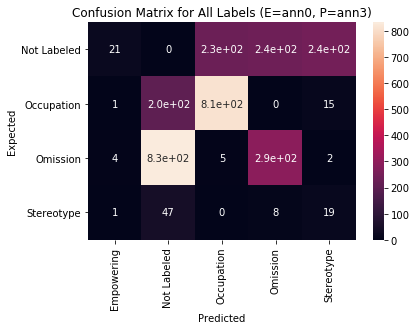

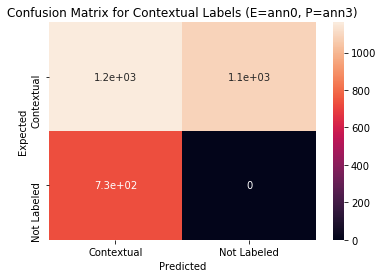

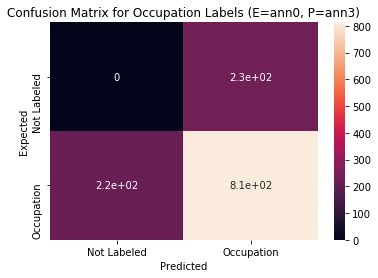

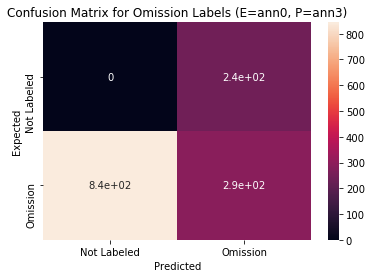

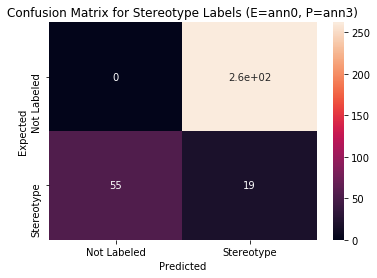

In [141]:
label_list = ["All", "Contextual", "Occupation", "Omission", "Stereotype"]
for label_choice in label_list:
    confusion_matrix = makeConfusionMatrix(ann0C, ann3, commonC03, label_choice)
#     print(confusion_matrix)
    fig = sn.heatmap(confusion_matrix, annot=True)
    title = "Confusion Matrix for "+label_choice+" Labels (E=ann0, P=ann3)"
    fig.set_title(title)
    name = "CM_"+label_choice+"_ann0ann3.png"
    plt.savefig(name)
    plt.show()

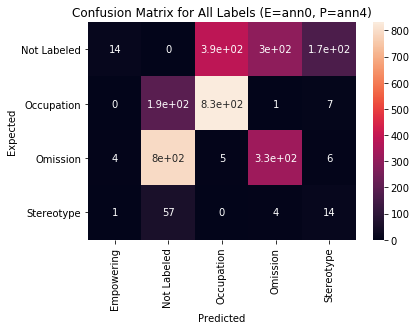

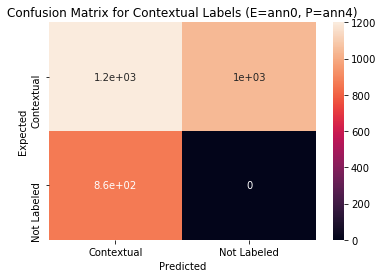

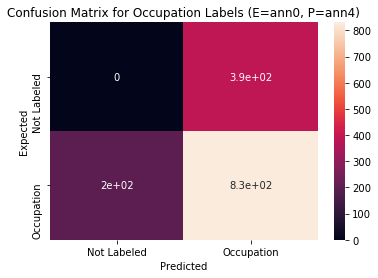

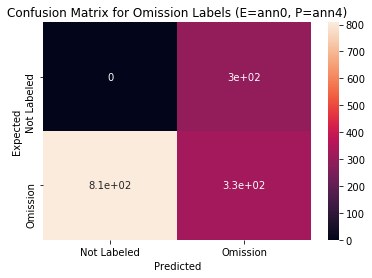

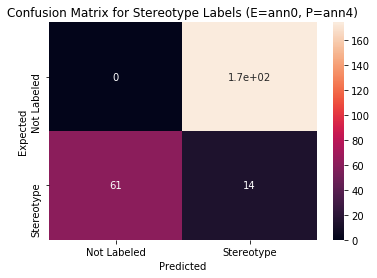

In [144]:
# label_list = ["All", "Contextual", "Occupation", "Omission", "Stereotype"]
for label_choice in label_list:
    confusion_matrix = makeConfusionMatrix(ann0C, ann4, commonC04, label_choice)
#     print(confusion_matrix)
    fig = sn.heatmap(confusion_matrix, annot=True)
    title = "Confusion Matrix for "+label_choice+" Labels (E=ann0, P=ann4)"
    fig.set_title(title)
    name = "CM_"+label_choice+"_ann0ann4.png"
    plt.savefig(name)
    plt.show()

<a id="stopped-here"></a>

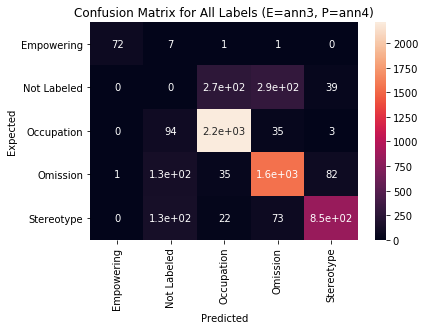

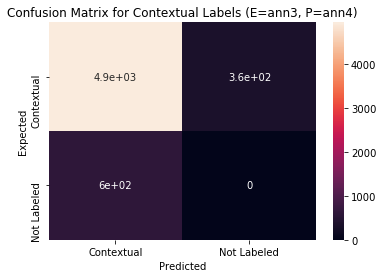

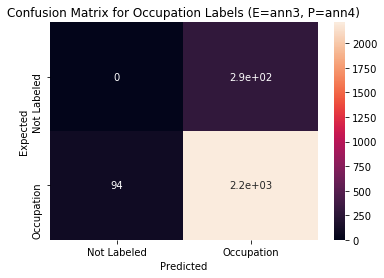

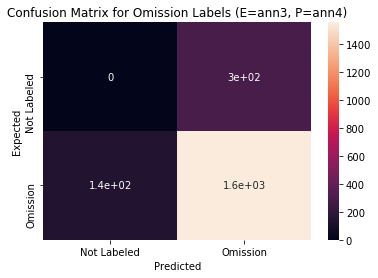

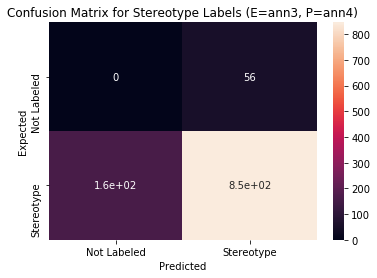

In [145]:
# label_list = ["All", "Contextual", "Occupation", "Omission", "Stereotype"]
for label_choice in label_list:
    confusion_matrix = makeConfusionMatrix(ann3, ann4, commonC34, label_choice)
#     print(confusion_matrix)
    fig = sn.heatmap(confusion_matrix, annot=True)
    title = "Confusion Matrix for "+label_choice+" Labels (E=ann3, P=ann4)"
    fig.set_title(title)
    name = "CM_"+label_choice+"_ann3ann4.png"
    plt.savefig(name)
    plt.show()

<a id="ling-pers"></a>
#### II.ii.b LINGUISTIC & PERSON-NAME LABEL ANALYSIS
* Linguistic labels include Gendered-Pronoun, Gendered-Role, and Generalization.
* Person-Name labels include Woman, Man, Nonbinary, and Unknown.
* Annotators include annotator 0 (ann0PL), annotator 1 (ann1), and annotator 2 (ann2).
*Question: Okay not to calculate true negatives???*

In [95]:
ann0PL.head()

,file,entity,label,start,end,text,annotator
0,AA4_00100.ann,T0,Gendered-Pronoun,645,647,he,Annotator 0
1,AA4_00100.ann,T1,Gendered-Pronoun,702,704,he,Annotator 0
2,AA4_00100.ann,T2,Gendered-Pronoun,913,915,he,Annotator 0
3,AA4_00100.ann,T3,Gendered-Pronoun,994,996,he,Annotator 0
4,AA4_00100.ann,T4,Gendered-Pronoun,1122,1124,he,Annotator 0


Count proportion of masculine and feminine terms for Gendered-Pronouns and Gendered-Roles, for annotator 0 and annotator 2.

In [51]:
# gp = ann0PL[ann0PL.label == "Gendered-Pronoun"]
gp = ann2[ann2.label == "Gendered-Pronoun"]
gp_counts = pd.DataFrame(gp.text.value_counts())
masc_counts = gp_counts.drop(["her", "she", "She", "Her"])
fem_counts = gp_counts.drop(["his", "he", "He", "His", "him", "himself"])
# gp_counts
total_masc_pronouns = masc_counts.text.sum()
total_fem_pronouns = fem_counts.text.sum()
total_pronouns = total_masc_pronouns+total_fem_pronouns
print("Masculine:",total_masc_pronouns, total_masc_pronouns/total_pronouns)
print("Feminine:",total_fem_pronouns, total_fem_pronouns/total_pronouns)
print("Files:",len(ann2.file.unique()))

Masculine: 4775 0.9057283763277694
Feminine: 497 0.09427162367223066
Files: 700


In [52]:
# gr = ann0PL[ann0PL.label == "Gendered-Role"]
gr = ann2[ann2.label == "Gendered-Role"]
gr_counts = pd.DataFrame(gr.text.value_counts())
gr.text.unique()
# masc_counts = gr_counts.drop(['son', 'brother', 'Chairman', 'man',
#         'Sir', 'Duke', 'father', 'father-in-law', 'King', 'husband', 'nephew', 
#         'Emperor',  "husband'", 'Mr', 'boy', 'Lord', 'men', 'son-in-law',
#         'Father', 'boys', 'Uncle', 'brothers', 'Man', 'Lad', 'Men', 'Boys'])
# fem_counts = gr_counts.drop(['sister', 'Woman', 'Women','wife', 'aunt', 'women',
#         'mother', 'matron', 'daughter', 'Princess', 'Queen', 
#         'Baroness', 'woman', 'female', 'Mrs', 'Wife',
#         'Miss', 'Maiden', 'Lady', 'Misses'])
masc_counts = gr_counts.drop(['Sir', 'Earl', 'men', 'man', 'boy',
       'boys', 'Mr', 'Mr.', 'King', 'Man', 'Gentleman', 'Duke', 'son', 'Men',
       'Prince', 'Son', 'Monsieur', 'sire', 'Brothers','Kaiser','Count', 'sons', 'High Priest',
       'ather', 'cowboy', 'cowboys', 'Baron', 'brother', 'Raja','sportsman', 'Bros', 'father', 
       'Viscount',  'Uncle', 'fathers', 'uncles', 'brothers', 'Emperor', 'Prince Regent', 'Englishman',
       'Founding Fathers', 'statesman', 'grandfather', 'Father', 'godfather', 'king',
       'Husband', 'Boy', 'Prince]', 'policeman', 'laird','MR', 'Laird', 'grandson', 'uncle', 'Sire', 
       'gentleman', 'baron', 'father-in-law','Archbishop', 'Sons', 'Chaplain', 'husband', 'nephew', 'His', 
       'men-at-arms', 'Pope','son-in-law', 'Boys', 'Lad', 'Archie', 'Laddie', 'husband,', "Man'", 'lads', 'Lads',
       'male', 'great-grandfather','Master of the Household', 'boys.'])
# Also dropped Waddington, Graeme D Eddie, MS, 'Blau, John', 'Granville Bantock'
fem_counts = gr_counts.drop(['Madame', 'Mrs', 'women','Princess', 'Lady', 'Lass', 'woman','Queen', 'girl',
       'daughter', 'foster-mother', 'wife', 'foster-mothers', 'mother',
       'sister', 'Senora', 'Miss','land-girls', 'Ladies','tribeswomen','Head Girl', 'heroine',
       'Mamma', 'father', 'grandmother,', 'maternal','Marquess', 'Widows', "Widows'", 'widows', 'sisters',
       'Emperor', 'Empresses','ladies', 'Empress Dowager', 'Empress', 'Tsarina',
       'great-granddaughter', 'authoress', 'Dame', 'suffragettes', 'Women', 'Countess', 'grandmother', 'MS',
       'queens', 'governesses', 'girls','Duchess', 'Aunt', 'Woman', 'Sister', 'Ms', 'laird',
       'LADY', 'ms', 'Viscountess','miss', 'Maid','matron', 'mother)', 'aunts', 'Baroness',
       'Girls', 'Wife',"wife'", 'Maiden', "Seal-Woman'", 'Misses','Sister,', 'Daughter', 
       'Mermaid', 'Maidens', "Maiden'",'Mother', 'Dairymaid', 'Mrs.','Lassie', "Women'",'womwn','widow'])
total_masc_roles = masc_counts.text.sum()
total_fem_roles = fem_counts.text.sum()
total_roles = total_masc_roles+total_fem_roles
print("Masculine:",total_masc_roles, total_masc_roles/total_roles)
print("Feminine:",total_fem_roles, total_fem_roles/total_roles)
# print("Files:",len(ann0PL.file.unique()))
print("Files:",len(ann2.file.unique()))

Masculine: 1442 0.42650103519668736
Feminine: 1939 0.5734989648033126
Files: 700


In [50]:
ppl = pd.DataFrame(ann2.label.value_counts())
ppl.drop(["Gendered-Role", "Gendered-Pronoun", "Generalization"], axis=0, inplace=True)
# # print(ppl.label.sum())
# # ppl

In [49]:
mf_counts = pd.DataFrame({"Category":["Masculine", "Feminine"], "People":[ppl.loc["Man"][0], ppl.loc["Woman"][0]],
                          "Roles":[total_masc_roles, total_fem_roles], "Pronouns":[total_masc_pronouns, total_fem_pronouns]})
mf_counts

,Category,People,Roles,Pronouns
0,Masculine,937,1442,4775
1,Feminine,849,1939,497


In [69]:
# ANNOTATOR 0
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

labels = ['People', 'Roles', 'Pronouns']
categories = ['Feminine', 'Masculine']   # no transgender or nonbinary data found in descriptions
colors = ['#0072B2', '#F0E442']
data = {'labels' : labels,
        'Feminine'   : [104, 132, 47],
        'Masculine'   : [304, 119, 326]}

# this creates [ ("Apples", "2015"), ("Apples", "2016"), ("Apples", "2017"), ("Pears", "2015), ... ]
x = [ (label, category) for label in labels for category in categories ]
counts = sum(zip(data['Feminine'], data['Masculine']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=250, 
           title="Annotator 0's Label Counts by Gender (nonbinary and trans data not provided)",
           toolbar_location=None)

p.vbar(x='x', top='counts', width=0.9, source=source,
      fill_color=factor_cmap('x', palette=colors, factors=categories, start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.outline_line_color = None

# show(p, notebook_handler=True)

In [64]:
# ANNOTATOR 2

output_file("masc_fem_counts2_700files.html")

labels = ['People', 'Roles', 'Pronouns']
categories = ['Feminine', 'Masculine']   # no transgender or nonbinary data found in descriptions
colors = ['#0072B2', '#F0E442']
data = {'labels' : labels,
        'Feminine'   : [849, 1939, 497],
        'Masculine'   : [937, 1442, 4775]}

# this creates [ ("Apples", "2015"), ("Apples", "2016"), ("Apples", "2017"), ("Pears", "2015), ... ]
x = [ (label, category) for label in labels for category in categories ]
counts = sum(zip(data['Feminine'], data['Masculine']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=250, 
           title="Annotator 2's Label Counts by Gender (nonbinary and trans data not provided)",
           toolbar_location=None)

p.vbar(x='x', top='counts', width=0.9, source=source,
      fill_color=factor_cmap('x', palette=colors, factors=categories, start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.outline_line_color = None

# show(p)

In [12]:
def splitAnnotation(annotation_list):
    list_of_landos = []
    for item in annotation_list:
        item_list = item.split(" ")
        list_of_landos += [item_list]
    label = []
    start = []
    end = []
    for l in list_of_landos:
        label += [l[0]]
        start += [l[1]]
        end += [l[2]]
    return label, start, end

In [13]:
def getLabelOffsets(label_type, df):
    rows = df[df.label == label_type]
    start = list(rows.start)
    end = list(rows.end)
    i = 0
    maxI = len(start)
    offsets = []
    while i < maxI:
        offsets += [[start[i], end[i]]]
        i += 1
    return offsets

In [14]:
label = ["Person-Name", "Woman", "Man", "Nonbinary", "Unknown", 
          "Linguistic", "Gendered-Role", "Gendered-Pronoun",  "Generalization", 
          "Contextual", "Occupation", "Stereotype", "Omission", "Empowering"]

# person = getLabelOffsets(label[0], df_ann)
# woman = getLabelOffsets(label[1], df_ann)
# man = getLabelOffsets(label[2], df_ann)
# nonbinary = getLabelOffsets(label[3], df_ann)
# unknown = getLabelOffsets(label[4], df_ann)
# linguistic = getLabelOffsets(label[5], df_ann)
role = getLabelOffsets(label[6], df_ann)
# pronoun = getLabelOffsets(label[7], df_ann)
# gen = getLabelOffsets(label[8], df_ann)
# cont = getLabelOffsets(label[9], df_ann)
# occ  = getLabelOffsets(label[10], df_ann)
# ster = getLabelOffsets(label[11], df_ann)
# omis = getLabelOffsets(label[12], df_ann)
# emp = getLabelOffsets(label[13], df_ann)

In [16]:
# df_ann = df_mann
# person_m = getLabelOffsets(label[0], df_ann)
# woman_m = getLabelOffsets(label[1], df_ann)
# man_m = getLabelOffsets(label[2], df_ann)
# nonbinary_m = getLabelOffsets(label[3], df_ann)
# unknown_m = getLabelOffsets(label[4], df_ann)
# linguistic_m = getLabelOffsets(label[5], df_ann)
role_m = getLabelOffsets(label[6], df_mann)
# pronoun_m = getLabelOffsets(label[7], df_ann)
# gen_m = getLabelOffsets(label[8], df_ann)
# cont_m = getLabelOffsets(label[9], df_ann)
# occ_m  = getLabelOffsets(label[10], df_ann)
# ster_m = getLabelOffsets(label[11], df_ann)
# omis_m = getLabelOffsets(label[12], df_ann)
# emp_m = getLabelOffsets(label[13], df_ann)

In [17]:
def findMatches(label_offsets1, label_offsets2):
    left_overlap = []
    right_overlap = []
    exact_match = []
    enclosure = []
    containment = []

    for pair in label_offsets1:
        start = pair[0]
        end = pair[1]
        for pair_m in label_offsets2:
            start_m = pair_m[0]
            end_m = pair_m[1]
            # Check for left overlap
            if start <= start_m and start < end_m and end >= start_m and end < end_m:
                if [pair, pair_m] not in left_overlap:
                    left_overlap += [[pair, pair_m]]
            # Check for right overlap 
            elif start > start_m and end >= end_m and start <= end_m and end > start_m:
                if [pair, pair_m] not in right_overlap:
                    right_overlap += [[pair, pair_m]]
            # Check for exact match
            elif start == start_m and end == end_m:
                if [pair, pair_m] not in exact_match:
                    exact_match += [[pair, pair_m]]
            # Check for enclosure
            elif start < start_m and start < end_m and end > start_m and end > end_m:
                if [pair, pair_m] not in enclosure:
                    enclosure += [[pair, pair_m]]
            # Check for containment
            elif start > start_m and start < end_m and end > start_m and end < end_m:
                if [pair, pair_m] not in containment:
                    containment += [[pair, pair_m]]
    
    return left_overlap, right_overlap, exact_match, enclosure, containment

<a id="bratiaa"></a>
### II.iv With bratiaa
Reference: https://github.com/kldtz/bratiaa

*Note: `nan` in F1 score indicates that no annotations have been recorded yet for that file in at least one of the annotator's files*
***
**Calculated for ann0's annotations as of June 14, 2021**
***

In [7]:
import os
from shutil import copyfile
import bratiaa as biaa

First, for each annotator, load the files and put the doubly-annotated files in a directory called second.

In [107]:
# # Contextual label files
# ann0C = "../IAA/Contextual/annotator-0"
ann3C = "../IAA/Contextual/annotator-3"
ann4C = "../IAA/Contextual/annotator-4"
# ann0C_files = list(os.listdir(ann0C))
ann3C_files = list(os.listdir(ann3C))
ann4C_files = list(os.listdir(ann4C))
# ann0C_files.sort()
ann3C_files.sort()
ann4C_files.sort()
# remove .stats_cache
# ann0C_files = ann0C_files[1:]
ann3C_files = ann3C_files[1:]
ann4C_files = ann4C_files[1:]

# # Linguistic label files
# ann0L = "../IAA/Linguistic/annotator-0"
# ann1L = "../IAA/Linguistic/annotator-1"
# ann2L = "../IAA/Linguistic/annotator-2"
# ann0L_files = list(os.listdir(ann0L))
# ann1L_files = list(os.listdir(ann1L))
# ann2L_files = list(os.listdir(ann2L))
# ann0L_files.sort()
# ann1L_files.sort()
# ann2L_files.sort()
# # remove .stats_cache
# ann0L_files = ann0L_files[1:]
# ann1L_files = ann1L_files[1:]
# ann2L_files = ann2L_files[1:]

print(ann4C_files[:10])

['AA4_00100.ann', 'AA4_00100.txt', 'AA5_00100.ann', 'AA5_00100.txt', 'AA6_00100.ann', 'AA6_00100.txt', 'AA7_00100.ann', 'AA7_00100.txt', 'BAI_00100.ann', 'BAI_00100.txt']


In [108]:
def getCommonFiles(filesA, filesB):
    common = []
    if len(filesA) <= len(filesB):
        short = filesA
        long = filesB
    else:
        short = filesB
        long = filesA
    for f in short:
        if f != "second":    # don't include the directory for doubly-annotated files
            if f in long:
                common += [f]
    return common

In [109]:
# commonC = getCommonFiles(ann0C_files, ann3C_files)
commonC = getCommonFiles(ann3C_files, ann4C_files)
print(len(commonC))

146


In [99]:
# commonL = getCommonFiles(ann0L_files, ann2L_files)
commonL = getCommonFiles(ann1L_files, ann2L_files)
print(len(commonL))

146


In [110]:
def moveFiles(file_list, source, dest):
    for f in file_list:
#         print(f)
        os.rename(os.path.join(source,f), os.path.join(dest,f))
    return "Files moved from",source, "to", dest

In [111]:
# moveFiles(commonC, ann0C, "../IAA/Contextual/annotator-0/second")
moveFiles(commonC, ann3C, "../IAA/Contextual/annotator-3/second")
moveFiles(commonC, ann4C, "../IAA/Contextual/annotator-4/second")
# moveFiles(commonL, ann0L, "../IAA/Linguistic/annotator-0/second")
# moveFiles(commonL, ann1L, "../IAA/Linguistic/annotator-1/second")
# moveFiles(commonL, ann2L, "../IAA/Linguistic/annotator-2/second")

('Files moved from',
 '../IAA/Contextual/annotator-4',
 'to',
 '../IAA/Contextual/annotator-4/second')

#### Linguistic Labels

In [102]:
project = '../IAA/Linguistic'

In [103]:
# instance-level agreement
f1_agreement = biaa.compute_f1_agreement(project)

# print agreement report to stdout
biaa.iaa_report(f1_agreement)

# agreement per label
label_mean, label_sd = f1_agreement.mean_sd_per_label()

# agreement per document
doc_mean, doc_sd = f1_agreement.mean_sd_per_document() 

# total agreement
total_mean, total_sd = f1_agreement.mean_sd_total()

# Inter-Annotator Agreement Report

* Instance-based F1 agreement

## Project Setup

* 2 annotators: annotator-1, annotator-2
* 73 agreement documents
* 14 labels

## Agreement per Document

| Document                   |   Mean F1 |   SD F1 |
|----------------------------|-----------|---------|
| second/AA4_00100.ann       |     0.875 |   0.000 |
| second/AA5_00100.ann       |     0.800 |   0.000 |
| second/AA6_00100.ann       |     0.808 |   0.000 |
| second/AA7_00100.ann       |     0.839 |   0.000 |
| second/BAI_00100.ann       |     0.667 |   0.000 |
| second/BAI_00200.ann       |     0.571 |   0.000 |
| second/BAI_00300.ann       |     0.615 |   0.000 |
| second/BAI_00400.ann       |     0.667 |   0.000 |
| second/BAI_00500.ann       |     0.750 |   0.000 |
| second/BAI_00600.ann       |     1.000 |   0.000 |
| second/BAI_00700.ann       |     0.667 |   0.000 |
| second/BAI_00800.ann       |     0.960 |   0.000 |
| second/BAI_00900.ann       |     1.000 |   0.000 |
| second/BAI_0

In [47]:
### Linguistic and Person-Name IAA 
### between ann0 and ann2 on 6/14/2021

# | Label            |   Mean F1 |   SD F1 |
# |------------------|-----------|---------|
# | Gendered-Pronoun |     0.994 |   0.000 |
# | Gendered-Role    |     0.672 |   0.000 |
# | Generalization   |     0.375 |   0.000 |
# | Man              |     0.549 |   0.000 |
# | Nonbinary        |   nan     | nan     |  # No nonbinary labels
# | Unknown          |     0.137 |   0.000 |
# | Woman            |     0.258 |   0.000 |


### Linguistic and Person-Name IAA 
### between ann1 and ann2 on 6/14/2021

# | Label            |   Mean F1 |   SD F1 |
# |------------------|-----------|---------|
# | Gendered-Pronoun |     0.977 |   0.000 |
# | Gendered-Role    |     0.703 |   0.000 |
# | Generalization   |     0.097 |   0.000 |
# | Man              |     0.534 |   0.000 |
# | Nonbinary        |   nan     | nan     |  # No nonbinary labels
# | Unknown          |     0.492 |   0.000 |
# | Woman            |     0.334 |   0.000 |

#### Contextual Labels

In [112]:
project = '../IAA/Contextual'

In [113]:
# instance-level agreement
f1_agreement = biaa.compute_f1_agreement(project)

# print agreement report to stdout
biaa.iaa_report(f1_agreement)

# agreement per label
label_mean, label_sd = f1_agreement.mean_sd_per_label()

# agreement per document
doc_mean, doc_sd = f1_agreement.mean_sd_per_document() 

# total agreement
total_mean, total_sd = f1_agreement.mean_sd_total()

# Inter-Annotator Agreement Report

* Instance-based F1 agreement

## Project Setup

* 2 annotators: annotator-3, annotator-4
* 73 agreement documents
* 14 labels

## Agreement per Document

| Document                   |   Mean F1 |   SD F1 |
|----------------------------|-----------|---------|
| second/AA4_00100.ann       |     0.762 |   0.000 |
| second/AA5_00100.ann       |     0.727 |   0.000 |
| second/AA6_00100.ann       |     0.743 |   0.000 |
| second/AA7_00100.ann       |     0.762 |   0.000 |
| second/BAI_00100.ann       |     0.500 |   0.000 |
| second/BAI_00200.ann       |     0.545 |   0.000 |
| second/BAI_00300.ann       |     0.667 |   0.000 |
| second/BAI_00400.ann       |   nan     | nan     |
| second/BAI_00500.ann       |     0.000 |   0.000 |
| second/BAI_00600.ann       |     1.000 |   0.000 |
| second/BAI_00700.ann       |     0.000 |   0.000 |
| second/BAI_00800.ann       |   nan     | nan     |
| second/BAI_00900.ann       |     0.000 |   0.000 |
| second/BAI_0

In [ ]:
### Agreement per Contextual Label between
### ann0 and ann3 as of 6/14/2021

# | Label            |   Mean F1 |   SD F1 |
# |------------------|-----------|---------|
# | Empowering       |     0.000 |   0.000 |
# | Occupation       |     0.556 |   0.000 |
# | Omission         |     0.269 |   0.000 |
# | Stereotype       |     0.046 |   0.000 |


### Agreement per Contextual Label between
### ann3 and ann4 as of 6/14/2021

# | Label            |   Mean F1 |   SD F1 |
# |------------------|-----------|---------|
# | Empowering       |     0.000 |   0.000 |
# | Occupation       |     0.607 |   0.000 |
# | Omission         |     0.403 |   0.000 |
# | Stereotype       |     0.027 |   0.000 |

# III. Merge Datasets
Reconcile the differences in the labeled data to create one gold standard dataset by:
1. For each label, review overlapping annotations with *different* labels and manually determine which is correct, and then add the correct annotations to a new DataFrame for the gold standard and remove the others from the old DataFrame.
2. For each label, review overlapping annotations with the *same* label and add the longest annotation to the gold standard DataFrame, and then remove the others from the old DataFrame.
3. For the remaining rows of the old DataFrame, for each `Occupation` label, remove any found to be incorrect during the manual review of those labels using grep from that DataFrame, and add those that are correct to the gold standard DataFrame.
4. For any files annotator 1 didn't label, add all annotator 0's `Gendered-Pronoun` labels.  For any files annotator 0 didn't label, add all annotator 2's `Gendered-Pronoun` labels.
5. For any files annotator 1 didn't label, add all annotator 0's `Gendered-Role` labels.  For any files annotator 0 didn't label, add all annotator 2's `Gendered-Role` labels.
6. Add all the remaining `Generalization` and `Stereotype` labels to the gold standard DataFrame.
7. Add all the remaining Person-Name labels from annotators 0 and 2 to the gold standard DataFrame.